In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Financial stocks

### First BanCorp (Small Cap)

In [5]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/FBP_data.csv")
print(df.head())

         Date  previous_1d      EMA_12  willr_14    OBV_7  labels
0  2000-01-21     100.0000  100.813609     -64.0 -21460.0     2.0
1  2000-01-24      97.1875  100.255746    -100.0 -28200.0     2.0
2  2000-01-25      96.2500   99.639478    -100.0 -32420.0     2.0
3  2000-01-26      93.1250   98.637250    -100.0 -42580.0     2.0
4  2000-01-27      94.0625   97.933443     -90.0 -36840.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [8]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [9]:
v = X.reshape(X.shape[0],15, 4)
v[0]

array([[1.        , 1.        , 0.93176471, 1.        ],
       [0.75      , 0.93848833, 0.        , 0.87536982],
       [0.66666667, 0.87053667, 0.        , 0.79733728],
       [0.38888889, 0.76002804, 0.        , 0.60946746],
       [0.47222222, 0.68242406, 0.25882353, 0.71560651],
       [0.44444444, 0.61145804, 0.17254902, 0.60909763],
       [0.38888889, 0.54080766, 0.16176471, 0.52662722],
       [0.16666667, 0.43861771, 0.        , 0.35576923],
       [0.11111111, 0.34154707, 0.06470588, 0.31767751],
       [0.        , 0.23820594, 0.31692677, 0.12536982],
       [0.        , 0.15076345, 0.31692677, 0.12536982],
       [0.30555556, 0.13508584, 1.        , 0.22337278],
       [0.22222222, 0.10591684, 0.82352941, 0.1397929 ],
       [0.11111111, 0.06003095, 0.58823529, 0.06102071],
       [0.        , 0.        , 0.36114911, 0.        ]])

In [10]:
y = labels
y = np.array(y)
y.shape

(4745,)

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [13]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2940 - accuracy: 0.5129 - mse: 0.4421 - weighted_accuracy: 0.2961 - weighted_mse: 0.5287 - val_loss: 0.2993 - val_accuracy: 0.0464 - val_mse: 0.3550 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3550
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2122 - accuracy: 0.3851 - mse: 0.7692 - weighted_accuracy: 0.4304 - weighted_mse: 0.7657 - val_loss: 0.2902 - val_accuracy: 0.0453 - val_mse: 0.3824 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3824
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1902 - accuracy: 0.3264 - mse: 1.0163 - weighted_accuracy: 0.4894 - weighted_mse: 0.9929 - val_loss: 0.2793 - val_accuracy: 0.0453 - val_mse: 0.4166 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4166
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1812 - accuracy: 0.3388 - mse: 1.1603 - weighted_accuracy: 0.5196 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1389 - accuracy: 0.4081 - mse: 1.5968 - weighted_accuracy: 0.7024 - weighted_mse: 1.5060 - val_loss: 0.1826 - val_accuracy: 0.4320 - val_mse: 1.6395 - val_weighted_accuracy: 0.4320 - val_weighted_mse: 1.6395
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1378 - accuracy: 0.4381 - mse: 1.6070 - weighted_accuracy: 0.6987 - weighted_mse: 1.5223 - val_loss: 0.1903 - val_accuracy: 0.3793 - val_mse: 1.5772 - val_weighted_accuracy: 0.3793 - val_weighted_mse: 1.5772
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1364 - accuracy: 0.4431 - mse: 1.6228 - weighted_accuracy: 0.7097 - weighted_mse: 1.5402 - val_loss: 0.1887 - val_accuracy: 0.3825 - val_mse: 1.6653 - val_weighted_accuracy: 0.3825 - val_weighted_mse: 1.6653
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1357 - accuracy: 0.4544 - mse: 1.6260 - weighted_accuracy: 0.7139 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1117 - accuracy: 0.5975 - mse: 1.9787 - weighted_accuracy: 0.7993 - weighted_mse: 1.9288 - val_loss: 0.1809 - val_accuracy: 0.4984 - val_mse: 2.0598 - val_weighted_accuracy: 0.4984 - val_weighted_mse: 2.0598
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1117 - accuracy: 0.6077 - mse: 2.0194 - weighted_accuracy: 0.8122 - weighted_mse: 1.9718 - val_loss: 0.1964 - val_accuracy: 0.4362 - val_mse: 2.0258 - val_weighted_accuracy: 0.4362 - val_weighted_mse: 2.0258
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1096 - accuracy: 0.5909 - mse: 2.0294 - weighted_accuracy: 0.8115 - weighted_mse: 1.9637 - val_loss: 0.1768 - val_accuracy: 0.5174 - val_mse: 2.1177 - val_weighted_accuracy: 0.5174 - val_weighted_mse: 2.1177
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1106 - accuracy: 0.5991 - mse: 2.0557 - weighted_accuracy: 0.8090 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0878 - accuracy: 0.7208 - mse: 2.6567 - weighted_accuracy: 0.8738 - weighted_mse: 2.6193 - val_loss: 0.1683 - val_accuracy: 0.6070 - val_mse: 2.8031 - val_weighted_accuracy: 0.6070 - val_weighted_mse: 2.8031
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0852 - accuracy: 0.7316 - mse: 2.6369 - weighted_accuracy: 0.8869 - weighted_mse: 2.6106 - val_loss: 0.2031 - val_accuracy: 0.5079 - val_mse: 2.8375 - val_weighted_accuracy: 0.5079 - val_weighted_mse: 2.8375
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0865 - accuracy: 0.7318 - mse: 2.6919 - weighted_accuracy: 0.8687 - weighted_mse: 2.6512 - val_loss: 0.1716 - val_accuracy: 0.6101 - val_mse: 2.8724 - val_weighted_accuracy: 0.6101 - val_weighted_mse: 2.8724
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0858 - accuracy: 0.7158 - mse: 2.7333 - weighted_accuracy: 0.8683 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0634 - accuracy: 0.8122 - mse: 3.7043 - weighted_accuracy: 0.9183 - weighted_mse: 3.5331 - val_loss: 0.1848 - val_accuracy: 0.6386 - val_mse: 3.8636 - val_weighted_accuracy: 0.6386 - val_weighted_mse: 3.8636
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0646 - accuracy: 0.8193 - mse: 3.7709 - weighted_accuracy: 0.9227 - weighted_mse: 3.5973 - val_loss: 0.1991 - val_accuracy: 0.5964 - val_mse: 3.8032 - val_weighted_accuracy: 0.5964 - val_weighted_mse: 3.8032
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0641 - accuracy: 0.8132 - mse: 3.7538 - weighted_accuracy: 0.9205 - weighted_mse: 3.5854 - val_loss: 0.1838 - val_accuracy: 0.6523 - val_mse: 4.0231 - val_weighted_accuracy: 0.6523 - val_weighted_mse: 4.0231
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0622 - accuracy: 0.8159 - mse: 3.8572 - weighted_accuracy: 0.9270 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0481 - accuracy: 0.8741 - mse: 5.2522 - weighted_accuracy: 0.9520 - weighted_mse: 4.8174 - val_loss: 0.1880 - val_accuracy: 0.6997 - val_mse: 5.4826 - val_weighted_accuracy: 0.6997 - val_weighted_mse: 5.4826
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0458 - accuracy: 0.8701 - mse: 5.2933 - weighted_accuracy: 0.9524 - weighted_mse: 4.8278 - val_loss: 0.1879 - val_accuracy: 0.7081 - val_mse: 5.4225 - val_weighted_accuracy: 0.7081 - val_weighted_mse: 5.4225
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0487 - accuracy: 0.8743 - mse: 5.3047 - weighted_accuracy: 0.9484 - weighted_mse: 4.8364 - val_loss: 0.1735 - val_accuracy: 0.7482 - val_mse: 5.7390 - val_weighted_accuracy: 0.7482 - val_weighted_mse: 5.7390
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0464 - accuracy: 0.8778 - mse: 5.3845 - weighted_accuracy: 0.9533 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0359 - accuracy: 0.9152 - mse: 7.3434 - weighted_accuracy: 0.9652 - weighted_mse: 6.3777 - val_loss: 0.2152 - val_accuracy: 0.7460 - val_mse: 7.5690 - val_weighted_accuracy: 0.7460 - val_weighted_mse: 7.5690
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0384 - accuracy: 0.9012 - mse: 7.2152 - weighted_accuracy: 0.9601 - weighted_mse: 6.4048 - val_loss: 0.2139 - val_accuracy: 0.7323 - val_mse: 7.2599 - val_weighted_accuracy: 0.7323 - val_weighted_mse: 7.2599
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0369 - accuracy: 0.9009 - mse: 7.2824 - weighted_accuracy: 0.9618 - weighted_mse: 6.3650 - val_loss: 0.1950 - val_accuracy: 0.7787 - val_mse: 7.9292 - val_weighted_accuracy: 0.7787 - val_weighted_mse: 7.9292
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0335 - accuracy: 0.9149 - mse: 7.4301 - weighted_accuracy: 0.9670 - 

In [17]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21126392483711243
Test accuracy: 0.7744994759559631


In [18]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.1145005  -3.5592313   2.7488492 ]
 [-2.773688   -3.3382635   2.2790854 ]
 [ 0.13538803 -5.5340605  -0.174957  ]
 ...
 [ 0.03065022 -4.9446607  -0.83112514]
 [-1.2220582  -2.121393   -0.06785342]
 [-2.0759692  -4.9031835   1.2937199 ]]


Counter({2: 794, 0: 93, 1: 62})

In [19]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 43})

In [20]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 3
actual buys but predicted sell: 3
actual buys but predicted hold: 37
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 34
actual holds but predicted buy: 59
actual holds but predicted sell: 81
actual predicted holds: 723
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 20.930232558139537%
Percentage holds correct: 83.77752027809966%
actual buys: 43
actual sells: 43
actual holds: 863


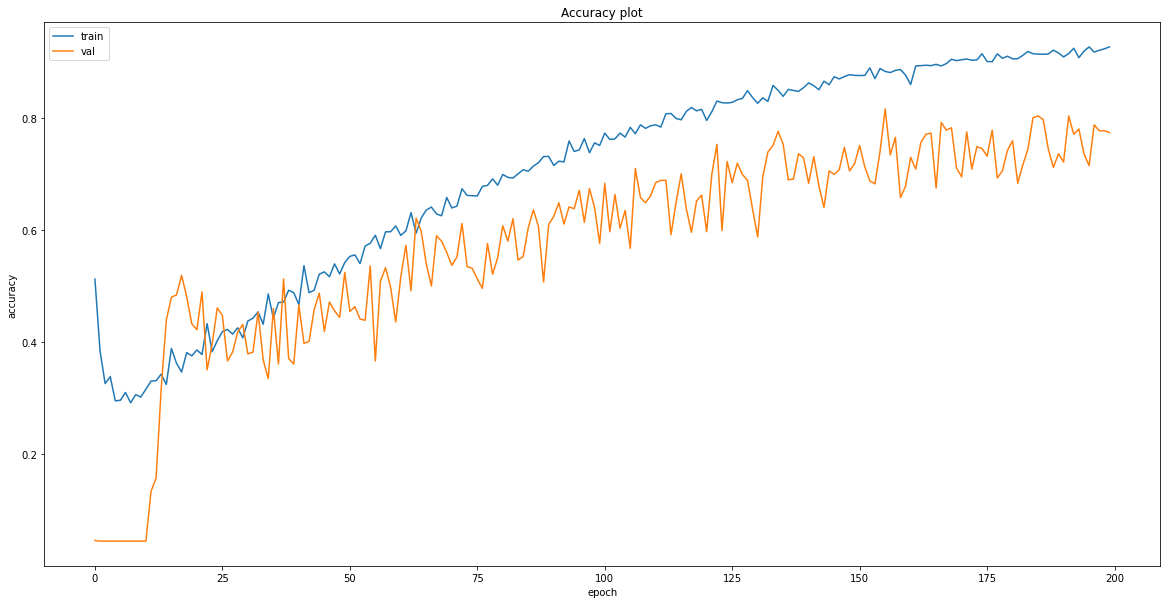

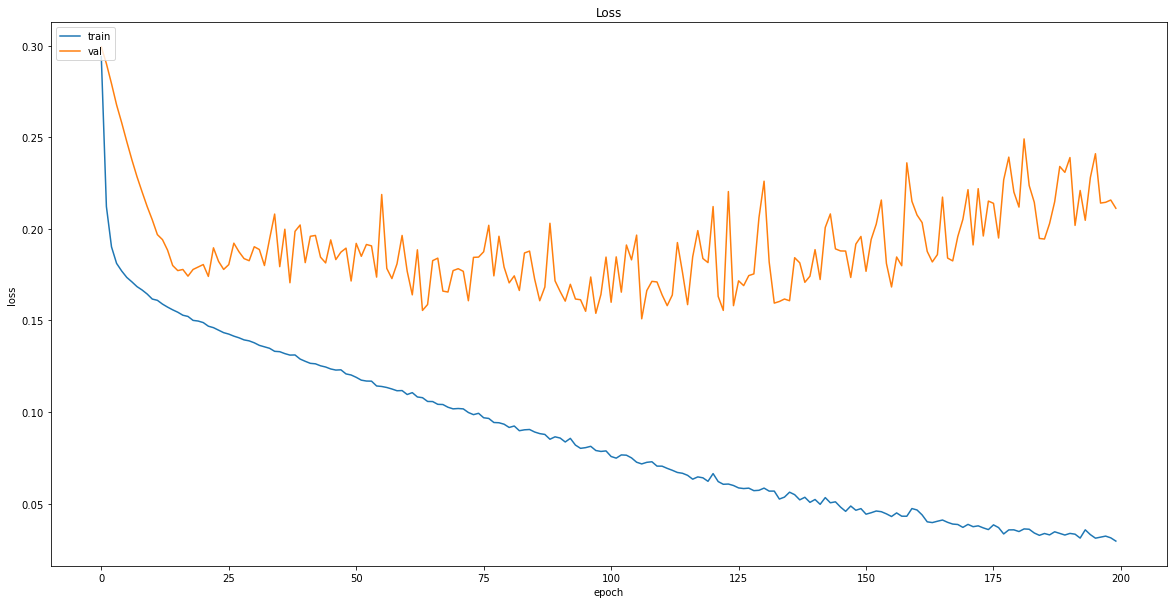

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
# Save model
model.save("models/{}".format('FBP_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/FBP_time_series_lstm_buy_hold_sell.model\assets


## American Financial Group, Inc. (Mid Cap)

In [23]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/AFG_data.csv")
print(df.head())

         Date  previous_1d     EMA_12    willr_14      OBV_7  labels
0  2000-01-21    15.000000  16.189452 -100.000000  -550650.0     2.0
1  2000-01-24    15.166667  16.032100  -93.103439  -477300.0     2.0
2  2000-01-25    14.875000  15.854085  -92.187507  -762150.0     2.0
3  2000-01-26    14.708333  15.677815  -95.454544 -1036650.0     2.0
4  2000-01-27    14.666667  15.522254  -88.888864 -1157250.0     2.0


In [24]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,15.000000,16.189452,-100.000000,-550650.0,2.0
2000-01-24,15.166667,16.032100,-93.103439,-477300.0,2.0
2000-01-25,14.875000,15.854085,-92.187507,-762150.0,2.0
2000-01-26,14.708333,15.677815,-95.454544,-1036650.0,2.0
2000-01-27,14.666667,15.522254,-88.888864,-1157250.0,2.0


In [25]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [26]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [27]:
y = labels
y = np.array(y)

In [28]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [29]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [30]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [32]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2927 - accuracy: 0.5140 - mse: 0.4573 - weighted_accuracy: 0.3123 - weighted_mse: 0.5308 - val_loss: 0.2992 - val_accuracy: 0.0453 - val_mse: 0.3541 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3541
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2122 - accuracy: 0.3527 - mse: 0.7833 - weighted_accuracy: 0.4460 - weighted_mse: 0.7677 - val_loss: 0.2897 - val_accuracy: 0.0453 - val_mse: 0.3845 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3845
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1905 - accuracy: 0.3003 - mse: 1.0555 - weighted_accuracy: 0.4777 - weighted_mse: 1.0282 - val_loss: 0.2779 - val_accuracy: 0.0453 - val_mse: 0.4234 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4234
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1840 - accuracy: 0.2977 - mse: 1.1763 - weighted_accuracy: 0.4894 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1407 - accuracy: 0.4012 - mse: 1.5827 - weighted_accuracy: 0.6966 - weighted_mse: 1.4923 - val_loss: 0.1852 - val_accuracy: 0.4162 - val_mse: 1.5735 - val_weighted_accuracy: 0.4162 - val_weighted_mse: 1.5735
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1392 - accuracy: 0.4418 - mse: 1.5741 - weighted_accuracy: 0.7078 - weighted_mse: 1.4991 - val_loss: 0.1930 - val_accuracy: 0.3541 - val_mse: 1.6152 - val_weighted_accuracy: 0.3541 - val_weighted_mse: 1.6152
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1380 - accuracy: 0.4257 - mse: 1.5932 - weighted_accuracy: 0.7219 - weighted_mse: 1.5130 - val_loss: 0.1902 - val_accuracy: 0.3804 - val_mse: 1.5285 - val_weighted_accuracy: 0.3804 - val_weighted_mse: 1.5285
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1376 - accuracy: 0.4431 - mse: 1.5891 - weighted_accuracy: 0.7210 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1137 - accuracy: 0.5896 - mse: 2.0281 - weighted_accuracy: 0.8057 - weighted_mse: 1.9589 - val_loss: 0.1972 - val_accuracy: 0.4278 - val_mse: 2.1450 - val_weighted_accuracy: 0.4278 - val_weighted_mse: 2.1450
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1106 - accuracy: 0.5772 - mse: 2.1003 - weighted_accuracy: 0.8248 - weighted_mse: 2.0481 - val_loss: 0.1781 - val_accuracy: 0.5090 - val_mse: 2.1825 - val_weighted_accuracy: 0.5090 - val_weighted_mse: 2.1825
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1093 - accuracy: 0.6191 - mse: 2.0975 - weighted_accuracy: 0.8275 - weighted_mse: 2.0561 - val_loss: 0.1989 - val_accuracy: 0.4552 - val_mse: 2.3495 - val_weighted_accuracy: 0.4552 - val_weighted_mse: 2.3495
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1085 - accuracy: 0.5980 - mse: 2.1144 - weighted_accuracy: 0.8252 - weig

30/30 [==============================] - 0s 7ms/step - loss: 0.0875 - accuracy: 0.7168 - mse: 2.8027 - weighted_accuracy: 0.8797 - weighted_mse: 2.7916 - val_loss: 0.1721 - val_accuracy: 0.5954 - val_mse: 3.0474 - val_weighted_accuracy: 0.5954 - val_weighted_mse: 3.0474
Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0850 - accuracy: 0.7187 - mse: 2.8235 - weighted_accuracy: 0.8858 - weighted_mse: 2.8019 - val_loss: 0.1636 - val_accuracy: 0.6217 - val_mse: 3.0162 - val_weighted_accuracy: 0.6217 - val_weighted_mse: 3.0162
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0816 - accuracy: 0.7297 - mse: 2.8586 - weighted_accuracy: 0.8972 - weighted_mse: 2.8435 - val_loss: 0.1755 - val_accuracy: 0.5869 - val_mse: 3.0614 - val_weighted_accuracy: 0.5869 - val_weighted_mse: 3.0614
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0826 - accuracy: 0.7194 - mse: 2.8989 - weighted_accuracy: 0.8879 - weighted_mse: 2.8

Epoch 116/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0621 - accuracy: 0.8127 - mse: 4.0060 - weighted_accuracy: 0.9276 - weighted_mse: 3.9084 - val_loss: 0.1806 - val_accuracy: 0.6301 - val_mse: 4.2284 - val_weighted_accuracy: 0.6301 - val_weighted_mse: 4.2284
Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0616 - accuracy: 0.8095 - mse: 4.0765 - weighted_accuracy: 0.9283 - weighted_mse: 4.0149 - val_loss: 0.1815 - val_accuracy: 0.6481 - val_mse: 4.5782 - val_weighted_accuracy: 0.6481 - val_weighted_mse: 4.5782
Epoch 118/200
30/30 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.7979 - mse: 4.1608 - weighted_accuracy: 0.9213 - weighted_mse: 4.092 - 0s 6ms/step - loss: 0.0617 - accuracy: 0.8058 - mse: 4.1691 - weighted_accuracy: 0.9233 - weighted_mse: 4.0784 - val_loss: 0.1609 - val_accuracy: 0.6965 - val_mse: 4.7135 - val_weighted_accuracy: 0.6965 - val_weighted_mse: 4.7135
Epoch 119/200
30/30 [================

30/30 [==============================] - 0s 6ms/step - loss: 0.0477 - accuracy: 0.8707 - mse: 5.5707 - weighted_accuracy: 0.9489 - weighted_mse: 5.2729 - val_loss: 0.1681 - val_accuracy: 0.7366 - val_mse: 6.2750 - val_weighted_accuracy: 0.7366 - val_weighted_mse: 6.2750
Epoch 145/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0470 - accuracy: 0.8601 - mse: 5.6377 - weighted_accuracy: 0.9468 - weighted_mse: 5.4121 - val_loss: 0.1836 - val_accuracy: 0.6997 - val_mse: 6.2531 - val_weighted_accuracy: 0.6997 - val_weighted_mse: 6.2531
Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0466 - accuracy: 0.8672 - mse: 5.7997 - weighted_accuracy: 0.9440 - weighted_mse: 5.5660 - val_loss: 0.1792 - val_accuracy: 0.7081 - val_mse: 6.1541 - val_weighted_accuracy: 0.7081 - val_weighted_mse: 6.1541
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0453 - accuracy: 0.8691 - mse: 5.7517 - weighted_accuracy: 0.9520 - weighted_mse: 

Epoch 173/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0378 - accuracy: 0.8967 - mse: 7.4686 - weighted_accuracy: 0.9585 - weighted_mse: 6.9339 - val_loss: 0.2165 - val_accuracy: 0.6849 - val_mse: 7.8310 - val_weighted_accuracy: 0.6849 - val_weighted_mse: 7.8310
Epoch 174/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0360 - accuracy: 0.8986 - mse: 7.6145 - weighted_accuracy: 0.9591 - weighted_mse: 7.0315 - val_loss: 0.1906 - val_accuracy: 0.7482 - val_mse: 8.0915 - val_weighted_accuracy: 0.7482 - val_weighted_mse: 8.0915
Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0346 - accuracy: 0.9115 - mse: 7.6989 - weighted_accuracy: 0.9675 - weighted_mse: 7.0733 - val_loss: 0.1880 - val_accuracy: 0.7555 - val_mse: 8.2672 - val_weighted_accuracy: 0.7555 - val_weighted_mse: 8.2672
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0376 - accuracy: 0.8983 - mse: 7.6653 - weighted_accuracy: 0.9572 - 

In [33]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.217581108212471
Test accuracy: 0.741833508014679


In [34]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.4636396  -7.7078404   0.65794474]
 [-1.790708   -2.5779402   0.34924322]
 [-2.4409761  -2.560898    0.5262026 ]
 ...
 [-3.9678135  -2.2366374   1.3567932 ]
 [ 1.9305516  -4.496227   -2.1956751 ]
 [-0.95415837 -2.4017785  -0.14776354]]


Counter({2: 761, 1: 73, 0: 115})

In [35]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 44, 1: 43})

In [36]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 35
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 36
actual holds but predicted buy: 67
actual holds but predicted sell: 105
actual predicted holds: 690
Percentage buys correct: 13.953488372093023%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 80.04640371229698%
actual buys: 43
actual sells: 44
actual holds: 862


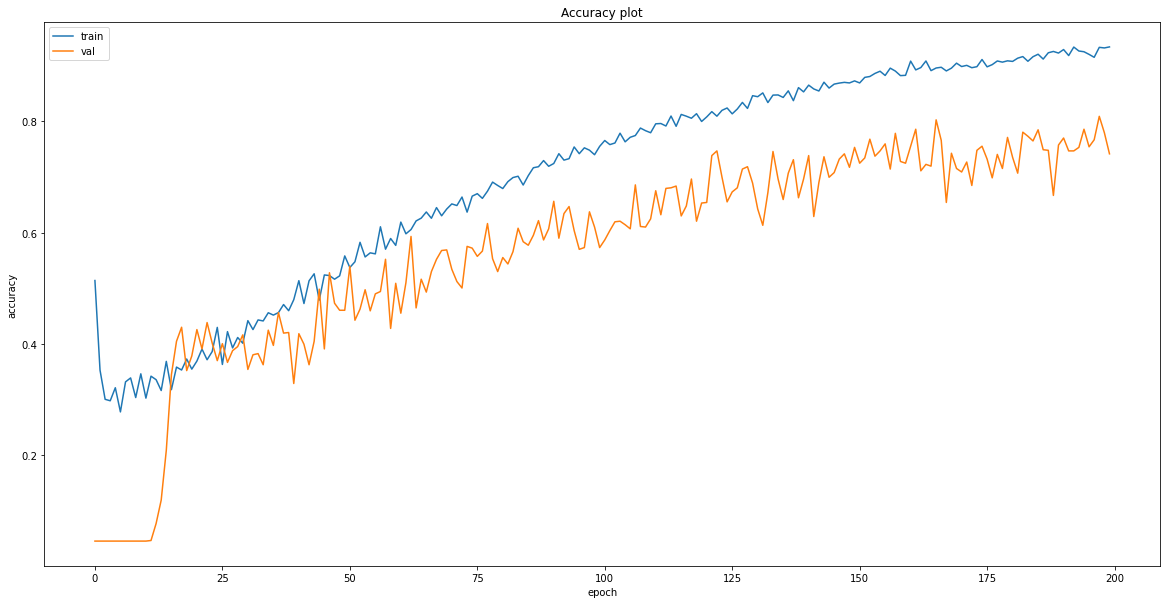

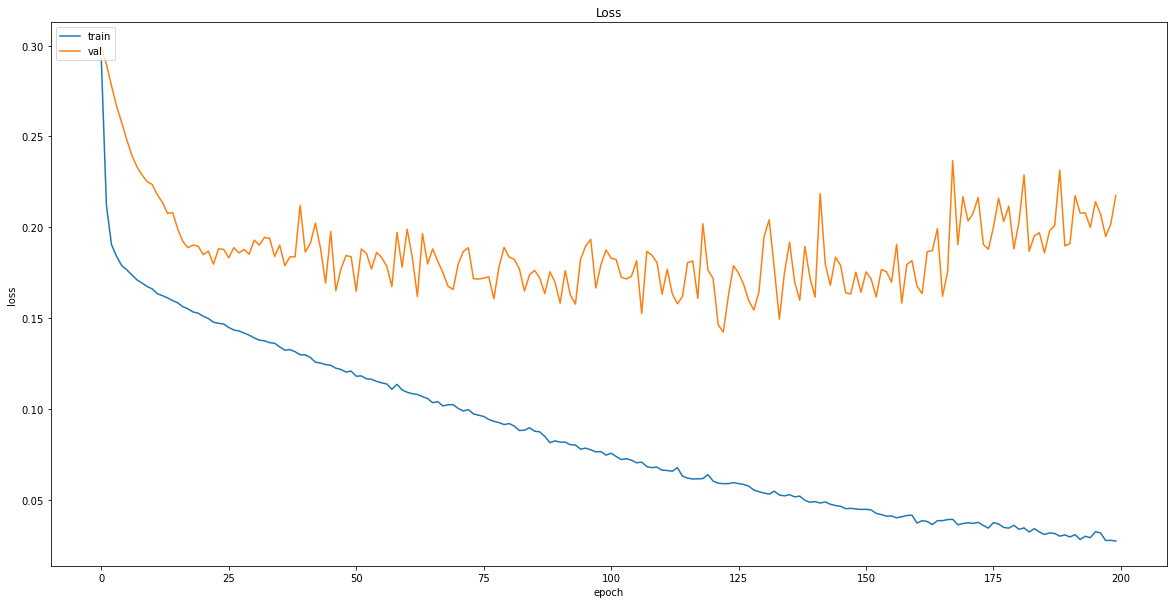

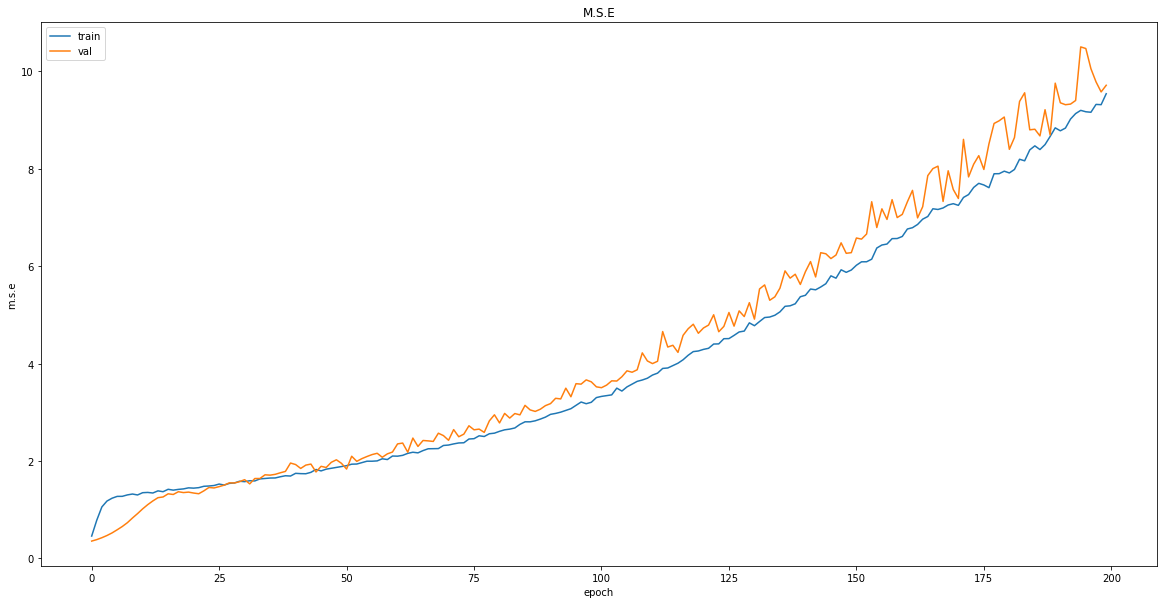

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
# Save model
model.save("models/{}".format('AFG_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/AFG_time_series_lstm_buy_hold_sell.model\assets


## JPMorgan Chase & Co. (Large Cap)

In [39]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/JPM_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


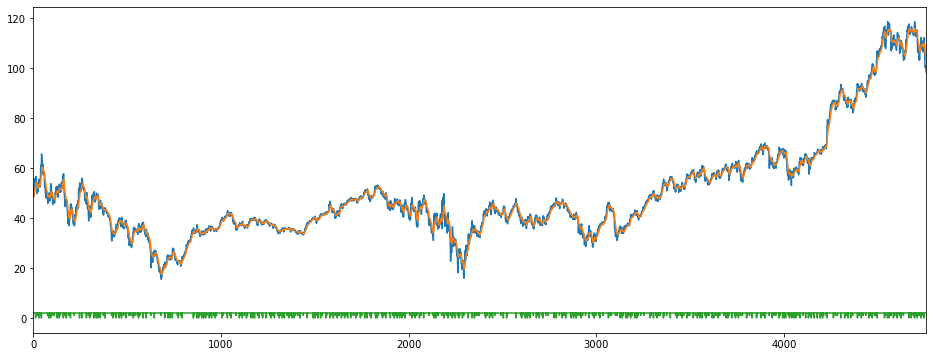

In [40]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [41]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [42]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [43]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [44]:
y = labels
y = np.array(y)

In [45]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [46]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [47]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [49]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2933 - accuracy: 0.4739 - mse: 0.4764 - weighted_accuracy: 0.3122 - weighted_mse: 0.5405 - val_loss: 0.2998 - val_accuracy: 0.0464 - val_mse: 0.3545 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3545
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2100 - accuracy: 0.3617 - mse: 0.7986 - weighted_accuracy: 0.4383 - weighted_mse: 0.7762 - val_loss: 0.2911 - val_accuracy: 0.0453 - val_mse: 0.3855 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3855
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1892 - accuracy: 0.2906 - mse: 1.0356 - weighted_accuracy: 0.4829 - weighted_mse: 1.0000 - val_loss: 0.2802 - val_accuracy: 0.0453 - val_mse: 0.4268 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4268
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1810 - accuracy: 0.2626 - mse: 1.1820 - weighted_accuracy: 0.4988 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1330 - accuracy: 0.4202 - mse: 1.7769 - weighted_accuracy: 0.7252 - weighted_mse: 1.6899 - val_loss: 0.1812 - val_accuracy: 0.4141 - val_mse: 1.6936 - val_weighted_accuracy: 0.4141 - val_weighted_mse: 1.6936
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1327 - accuracy: 0.4378 - mse: 1.7816 - weighted_accuracy: 0.7317 - weighted_mse: 1.6980 - val_loss: 0.1991 - val_accuracy: 0.3340 - val_mse: 1.8541 - val_weighted_accuracy: 0.3340 - val_weighted_mse: 1.8541
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1311 - accuracy: 0.4265 - mse: 1.7939 - weighted_accuracy: 0.7426 - weighted_mse: 1.7150 - val_loss: 0.1893 - val_accuracy: 0.3741 - val_mse: 1.8014 - val_weighted_accuracy: 0.3741 - val_weighted_mse: 1.8014
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1304 - accuracy: 0.4347 - mse: 1.8016 - weighted_accuracy: 0.7399 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1063 - accuracy: 0.6125 - mse: 2.3047 - weighted_accuracy: 0.8316 - weighted_mse: 2.2762 - val_loss: 0.1762 - val_accuracy: 0.5100 - val_mse: 2.4568 - val_weighted_accuracy: 0.5100 - val_weighted_mse: 2.4568
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1067 - accuracy: 0.6083 - mse: 2.3268 - weighted_accuracy: 0.8263 - weighted_mse: 2.3032 - val_loss: 0.1792 - val_accuracy: 0.5163 - val_mse: 2.4999 - val_weighted_accuracy: 0.5163 - val_weighted_mse: 2.4999
Epoch 61/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1063 - accuracy: 0.6072 - mse: 2.3314 - weighted_accuracy: 0.8221 - weighted_mse: 2.3009 - val_loss: 0.1879 - val_accuracy: 0.4858 - val_mse: 2.5595 - val_weighted_accuracy: 0.4858 - val_weighted_mse: 2.5595
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1043 - accuracy: 0.5991 - mse: 2.4029 - weighted_accuracy: 0.8210 - weig

Epoch 88/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0830 - accuracy: 0.7239 - mse: 3.1850 - weighted_accuracy: 0.8857 - weighted_mse: 3.1621 - val_loss: 0.1630 - val_accuracy: 0.6112 - val_mse: 3.3301 - val_weighted_accuracy: 0.6112 - val_weighted_mse: 3.3301
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0799 - accuracy: 0.7334 - mse: 3.2176 - weighted_accuracy: 0.8855 - weighted_mse: 3.2099 - val_loss: 0.1499 - val_accuracy: 0.6712 - val_mse: 3.4895 - val_weighted_accuracy: 0.6712 - val_weighted_mse: 3.4895
Epoch 90/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0808 - accuracy: 0.7237 - mse: 3.3245 - weighted_accuracy: 0.8837 - weighted_mse: 3.3211 - val_loss: 0.1675 - val_accuracy: 0.6027 - val_mse: 3.4900 - val_weighted_accuracy: 0.6027 - val_weighted_mse: 3.4900
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0800 - accuracy: 0.7339 - mse: 3.2833 - weighted_accuracy: 0.8876 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0617 - accuracy: 0.8051 - mse: 4.4643 - weighted_accuracy: 0.9191 - weighted_mse: 4.3257 - val_loss: 0.1894 - val_accuracy: 0.6038 - val_mse: 4.7850 - val_weighted_accuracy: 0.6038 - val_weighted_mse: 4.7850
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0615 - accuracy: 0.8016 - mse: 4.6444 - weighted_accuracy: 0.9237 - weighted_mse: 4.5162 - val_loss: 0.1833 - val_accuracy: 0.6449 - val_mse: 5.0654 - val_weighted_accuracy: 0.6449 - val_weighted_mse: 5.0654
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0591 - accuracy: 0.8203 - mse: 4.5961 - weighted_accuracy: 0.9324 - weighted_mse: 4.4527 - val_loss: 0.1683 - val_accuracy: 0.6965 - val_mse: 4.8671 - val_weighted_accuracy: 0.6965 - val_weighted_mse: 4.8671
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0562 - accuracy: 0.8330 - mse: 4.6678 - weighted_accuracy: 0.9351 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0447 - accuracy: 0.8788 - mse: 6.2370 - weighted_accuracy: 0.9500 - weighted_mse: 5.8465 - val_loss: 0.2002 - val_accuracy: 0.6923 - val_mse: 6.3380 - val_weighted_accuracy: 0.6923 - val_weighted_mse: 6.3380
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0446 - accuracy: 0.8720 - mse: 6.3136 - weighted_accuracy: 0.9513 - weighted_mse: 5.9386 - val_loss: 0.2032 - val_accuracy: 0.6712 - val_mse: 6.7774 - val_weighted_accuracy: 0.6712 - val_weighted_mse: 6.7774
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0434 - accuracy: 0.8786 - mse: 6.4879 - weighted_accuracy: 0.9537 - weighted_mse: 6.0235 - val_loss: 0.2003 - val_accuracy: 0.6976 - val_mse: 7.0359 - val_weighted_accuracy: 0.6976 - val_weighted_mse: 7.0359
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0457 - accuracy: 0.8709 - mse: 6.4767 - weighted_accuracy: 0.9470 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0355 - accuracy: 0.9081 - mse: 8.4351 - weighted_accuracy: 0.9626 - weighted_mse: 7.6998 - val_loss: 0.2145 - val_accuracy: 0.7187 - val_mse: 8.4143 - val_weighted_accuracy: 0.7187 - val_weighted_mse: 8.4143
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9086 - mse: 8.4747 - weighted_accuracy: 0.9628 - weighted_mse: 7.6898 - val_loss: 0.1950 - val_accuracy: 0.7935 - val_mse: 9.1907 - val_weighted_accuracy: 0.7935 - val_weighted_mse: 9.1907
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0342 - accuracy: 0.9136 - mse: 8.4845 - weighted_accuracy: 0.9628 - weighted_mse: 7.6940 - val_loss: 0.1998 - val_accuracy: 0.7534 - val_mse: 9.3251 - val_weighted_accuracy: 0.7534 - val_weighted_mse: 9.3251
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0320 - accuracy: 0.9154 - mse: 8.5275 - weighted_accuracy: 0.9671 - 

In [50]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2134251743555069
Test accuracy: 0.7818756699562073


In [51]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.53184    -4.8776703   1.4442985 ]
 [-2.6212025  -3.6205554   1.7546833 ]
 [-3.9757135  -6.451978    3.077517  ]
 ...
 [-0.05519691 -3.752302   -0.21106   ]
 [-1.8996837  -2.7683666   0.5460466 ]
 [-2.0061731  -3.6519043   1.6288614 ]]


Counter({2: 811, 0: 72, 1: 66})

In [52]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [53]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 38
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 38
actual holds but predicted buy: 62
actual holds but predicted sell: 68
actual predicted holds: 735
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 84.97109826589596%
actual buys: 43
actual sells: 41
actual holds: 865


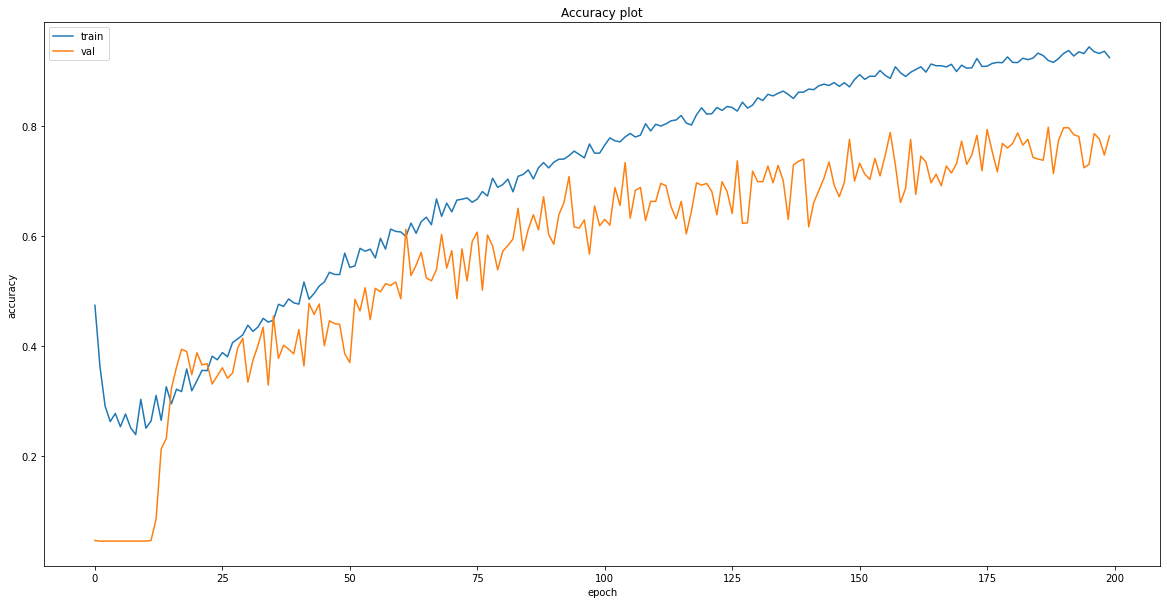

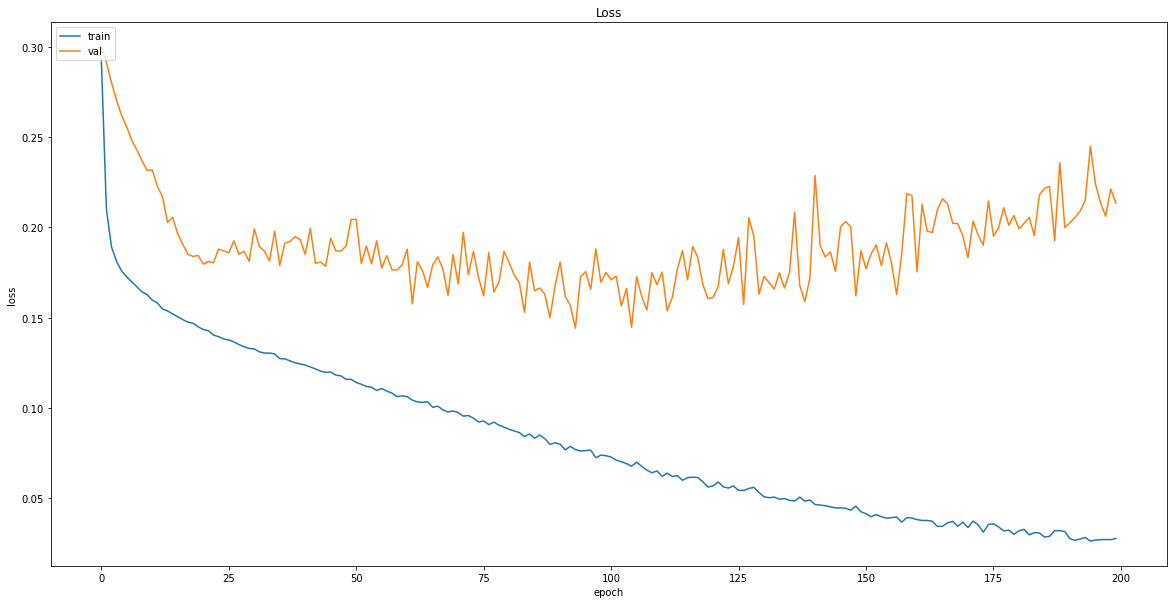

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [55]:
# Save model
model.save("models/{}".format('JPM_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/JPM_time_series_lstm_buy_hold_sell.model\assets
